In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# 导入MNIST数据集
mnist = input_data.read_data_sets('data/fashion', one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [2]:
#生成tf.record文件
def tfrecords(type):
    data_type = {"train":mnist.train, "validation":mnist.validation, "test":mnist.test}
    x = data_type[type].images[:,:]
    y = data_type[type].labels[:,:]
    with tf.python_io.TFRecordWriter('data/data_tfrecord/' + type + '.tfrecords') as writer:
        for i in range(len(x)):
            b1 = x[i].tobytes()
            b2 = y[i].tobytes()
            f1 = tf.train.Feature(bytes_list=tf.train.BytesList(value=[b1]))
            f2 = tf.train.Feature(bytes_list=tf.train.BytesList(value=[b2]))
            features = tf.train.Features(feature={'f1': f1, 'f2': f2})
            example = tf.train.Example(features=features)
            writer.write(example.SerializeToString())
    print("training...ok")

tfrecords("train")
tfrecords("validation")
tfrecords("test")

training...ok
training...ok
training...ok


In [5]:
#数据处理
def dataset(data_type='train', batch_size=10):
    # 创建队列保护输入文件列表
    filename_queue = tf.train.string_input_producer(['data/data_tfrecord/' + data_type + '.tfrecords'])  
    # 读取并解析一个tfrecord
    reader = tf.TFRecordReader()  
    _, serialized_example = reader.read(filename_queue)
    example = tf.parse_single_example(serialized_example, features={
        'f1': tf.FixedLenFeature([], tf.string),
        'f2': tf.FixedLenFeature([], tf.string)})
    # 将字符串分别解析成标签和图像对应的像素组（并重组）
    image = tf.decode_raw(example['f1'], tf.float32)
    label = tf.decode_raw(example['f2'], tf.float64)
    image = tf.reshape(image, [28, 28])
    label= tf.reshape(label,[1,10])
    
    img_batch, l_batch = tf.train.shuffle_batch(
        [image, label],
        batch_size=batch_size,
        capacity= (3 * batch_size),
        min_after_dequeue=batch_size)
    return img_batch, l_batch

In [6]:
# 数据格式转换
def change(Y):
    s,d,f = Y.shape
    b = np.empty((s,d*f))
    for i in range(s):
        c=Y[i]
        b[i]=c.reshape(d*f)
    Y=b
    return Y

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


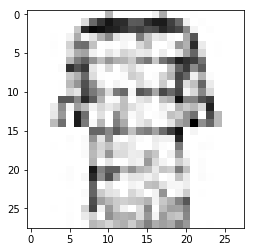

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


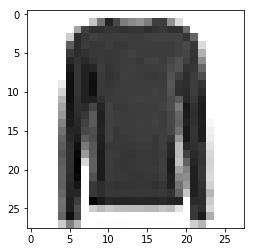

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


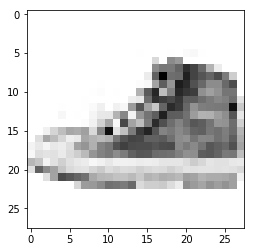

In [7]:
#可视化
def visualization(img_batch, l_batch):
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)  
        coord = tf.train.Coordinator() 
        threads=tf.train.start_queue_runners(sess=sess,coord=coord)
        for i in range(3):
            img, label = sess.run([img_batch, l_batch]) 
            img0=img[0]
            plt.imshow(img0, cmap=plt.get_cmap('gray_r'))
            print(label[0])
            plt.show()
        coord.request_stop()
        coord.join(threads)

train_img, train_label = dataset(batch_size=10)
visualization(train_img, train_label)